In [1]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone

from sklearn.model_selection import StratifiedKFold  # stratified sampling
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve

from sklearn.preprocessing import StandardScaler

import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Fetch Data
df_X, df_y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [98]:
# MNIST comes (aparently) already in separated train - test set (last 10,000 images)
X = df_X.to_numpy()
y = df_y.to_numpy()
X = X / 255.

train_samps = 67500
X_train, X_test, y_train, y_test = X[:train_samps], X[train_samps:], y[:train_samps], y[train_samps:]
# Shuffle train set
shuffled_idx = np.random.permutation(train_samps)
X_train, y_train = X_train[shuffled_idx], y_train[shuffled_idx]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))  # not sure why this makes sense here
X_test_scaled = scaler.fit_transform(X_test.astype(np.float64))

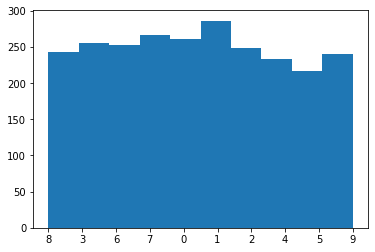

array(['8', '7', '8', '8', '7', '7', '4', '0', '1', '0', '1', '7', '0',
       '4', '8', '7', '3', '4', '7', '2', '6', '4', '5', '9', '0', '7',
       '4', '5', '4', '6'], dtype=object)

In [58]:
plt.hist(y_test)
plt.show()

y_train[:30]

### Data Augmentation

In [86]:
from scipy.ndimage.interpolation import shift

shifts = {1: [0, 1], 2: [0, -1], 3: [1, 0], 4: [-1, 0]}

X_train_aug = np.zeros((train_samps * len(shifts), 784), dtype=np.float64)
y_train_aug = np.empty(train_samps * len(shifts), dtype=str)
# zeros (parenthesis), empty (no parenthesis), append, vstack & hstack (brackets)

img_idx = 0
for idx, (img, label) in enumerate(zip(X_train, y_train)):

    if idx % 500 == 0: print(f"{idx} processed images")
    
    for num in range(1, 5):
        X_train_aug[img_idx, :] = shift(img.reshape(28, 28), shifts[num]).reshape(1, 784)
        y_train_aug[img_idx] = label
        img_idx += 1

X_train_aug = np.vstack([X_train, X_train_aug])
y_train_aug = np.hstack([y_train, y_train_aug])
print(f"Train test shape {X_train_aug.shape}, labels shape {y_train_aug.shape}")
        

0 processed images
500 processed images
1000 processed images
1500 processed images
2000 processed images
2500 processed images
3000 processed images
3500 processed images
4000 processed images
4500 processed images
5000 processed images
5500 processed images
6000 processed images
6500 processed images
7000 processed images
7500 processed images
8000 processed images
8500 processed images
9000 processed images
9500 processed images
10000 processed images
10500 processed images
11000 processed images
11500 processed images
12000 processed images
12500 processed images
13000 processed images
13500 processed images
14000 processed images
14500 processed images
15000 processed images
15500 processed images
16000 processed images
16500 processed images
17000 processed images
17500 processed images
18000 processed images
18500 processed images
19000 processed images
19500 processed images
20000 processed images
20500 processed images
21000 processed images
21500 processed images
22000 proces

(337500,)

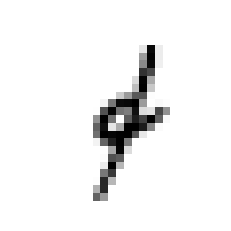

'4'

In [90]:
# Data sanity check
img_num = 335000
plt.imshow(X_train[img_num, :].reshape(28, 28), cmap=matplotlib.cm.binary)
plt.axis('off')
plt.show()
y_train[img_num]

# Binary Classification (5 vs non 5)

In [5]:
# Binary Classifier [5 vs non 5]
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [6]:
# test one prediction
num = 7171
predictions = sgd_clf.predict(X_train[num,:].reshape(1, 784))
print(predictions, y_train[num])

[False] 9


In [7]:
# Evaluate accuracy on the test set
predictions = sgd_clf.predict(X_test)
test_accuracy = np.mean( [ 1 if (prediction == True and label =='5') or (prediction == False and label !='5') else 0 for prediction, label in zip(predictions, y_test)])
print(test_accuracy)
accuracy_score(predictions, y_test_5)


0.9781


0.9781

In [8]:
# Evaluate the test set with Cross Validation
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')


array([0.97105, 0.96635, 0.972  ])

In [9]:
# Compute the confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[54335,   244],
       [ 1568,  3853]])

In [11]:
# Precision,  Recall and F1 score
print(f"Precision: {precision_score(y_train_5, y_train_pred)}")
print(f"Recall: {recall_score(y_train_5, y_train_pred)}")
print(f"F1 score: {f1_score(y_train_5, y_train_pred)}")

Precision: 0.9404442274835245
Recall: 0.7107544733444014
F1 score: 0.8096238705610422


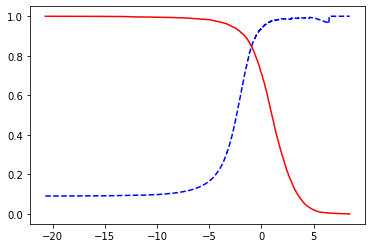

In [17]:
# Precision and recall tradeoff

# Select the decision threshold for the classifier
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

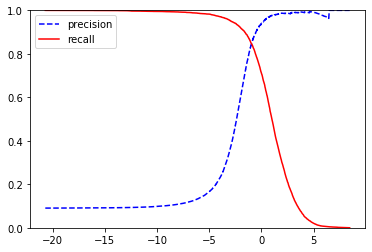

In [21]:
# Plot precision / recall tradeoff
plt.plot(thresholds, precisions[:-1], "b--", label="precision")
plt.plot(thresholds, recalls[:-1], "r-", label="recall")
plt.legend(loc="upper left")
plt.ylim([0, 1])
plt.show()

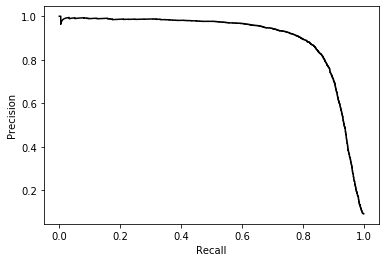

In [23]:
# plot precision / recall
plt.plot(recalls, precisions, "k-")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

ROC score: 0.9703224858223598


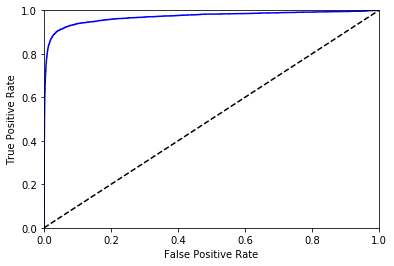

In [34]:
# ROC curve
print(f"ROC score: {roc_auc_score(y_train_5, y_scores)}")
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

plt.plot(fpr, tpr, 'b-')
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.axis([0, 1, 0, 1])
plt.show()

In [37]:
# Compare SGD with RandomForest
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [45]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
print(f"ROC AUC Random Forest {roc_auc_score(y_train_5, y_scores_forest)}")

ROC AUC Random Forest 0.9984970448056693


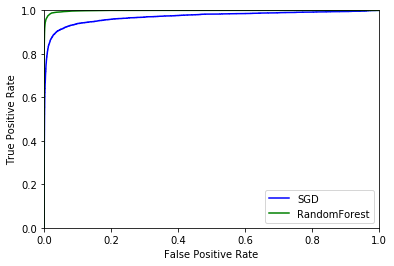

In [43]:
plt.plot(fpr, tpr, 'b-', label="SGD")
plt.plot(fpr_forest, tpr_forest, 'g-', label="RandomForest")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.axis([0, 1, 0, 1])
plt.show()

# Multilabel classification

In [46]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [61]:
# Predict class and Obtain probabilities for each class
num = 6546
y_pred = forest_clf.predict(X_train[num, :].reshape(1, 784))
y_proba = forest_clf.predict_proba(X_train[num, :].reshape(1, 784))
print(y_proba)
print(f"Predicted: {y_pred}, ground truth: {y_train[num]}, Probability: {np.argmax(y_proba)}")

# Total Accuracy
predictions = forest_clf.predict(X_train)
print(f"Accuracy: {accuracy_score(predictions, y_train)}")

[[0.   0.   0.   0.   0.01 0.   0.   0.02 0.   0.97]]
Predicted: ['9'], ground truth: 9, Probability: 9
Accuracy: 1.0


In [63]:
# Cross Validation
y_score = cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

In [71]:
# Scaling data improves performance

y_score_scaled = cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

print(y_score)
print(y_score_scaled)

[0.9652  0.96485 0.96715]


In [76]:
# Error Analysis: Confusion Matrix
y_train_pred = cross_val_predict(forest_clf, X_train_scaled, y_train, cv=3)
cfm = confusion_matrix(y_train, y_train_pred)


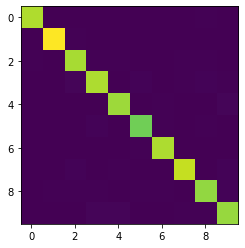

In [79]:
plt.imshow(cfm)
plt.show()

## Grid Search of hyperparameters

The optimal hyper-parameters are 'n_neighbors': 3, 'weights': 'distance'

In [99]:
param_grid = [{'n_neighbors': [3, 4, 5], 'weights': ['uniform', 'distance']}]
grid_search = GridSearchCV(knn_clf, param_grid, scoring="accuracy", cv=3, n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)
final_model = grid_search.best_estimator_
print(final_model)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
KNeighborsClassifier(n_neighbors=4, weights='distance')


In [100]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [102]:
cvres = grid_search.cv_results_
xx = [print(score, params) for score, params in zip(cvres["mean_test_score"], cvres["params"])]

0.9699555555555556 {'n_neighbors': 3, 'weights': 'uniform'}
0.9712740740740741 {'n_neighbors': 3, 'weights': 'distance'}
0.9680592592592592 {'n_neighbors': 4, 'weights': 'uniform'}
0.9718370370370372 {'n_neighbors': 4, 'weights': 'distance'}
0.9686814814814815 {'n_neighbors': 5, 'weights': 'uniform'}
0.9700000000000001 {'n_neighbors': 5, 'weights': 'distance'}


In [101]:
y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9856

# K-NNs classifier
Exercise 1 of chapter 3: 
Try to improve the accuracy to more than 97% on the test set. 

First we check the baseline results of the K-NNs classifier. As expected, we get 96.9% as the maximum score. We use the hyperparameters selected with the grid search. They reach 97% and 95% accuracy for train and test. 

With data augmentation: the more images the algorithm uses, the better the performance. I used 'shift' to add 4 times more data to the training set to try to reach >97% in the test set.
Results: 

In [103]:
knn_clf = KNeighborsClassifier(n_neighbors=4, weights='distance')
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [104]:
y_train_pred = cross_val_score(knn_clf, X_train, y_train, cv=3, scoring="accuracy")
print(f"Accuracy for train set: {y_train_pred}")

Accuracy for train set: [0.97266667 0.97102222 0.97182222]


In [105]:
predicted = knn_clf.predict(X_test)
print(f"Accuracy for the test set: {accuracy_score(y_test, predicted)}")


Accuracy for the test set: 0.9856
